<a href="https://colab.research.google.com/github/MatiasCovarrubias/jaxecon/blob/main/jaxDEQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEQN Solver in Jax.

This notebook trains a neural net to output the optimal policy of a nonlinear Rbc model.



In [ ]:
# Install dependencies
! pip install optax -q
! pip install flax -q


# the default is CPU
TPU = False # set True if using TPU runtime
GPU = False # if both TPU and GPU are false, we are using CPU
if TPU:
  !pip install --upgrade jax jaxlib 
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu('tpu_driver_20221011')
elif GPU:
  !nvidia-smi

# Imports
import jax
from jax import lax
from jax import random
from jax import numpy as jnp
from jax.config import config 
config.update("jax_debug_nans", True)
import flax.linen as nn
from flax.training import checkpoints
from flax.core import freeze, unfreeze
import optax
import time
from time import time
import timeit
from typing import Sequence
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import json

print(jax.devices())

# Mount Google Drive to store results
from google.colab import drive
drive.mount('/content/drive')

[CpuDevice(id=0)]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Import model structure and create policies

To start, we will import the parameters of the model and the loglinear policy.

### Create Neural Net policy

First, we use Flax to create the Neural Net, Notice that we activate the last layer using Softplus to guarantee that we get possitive outputs

In [ ]:
class MLP_softplus(nn.Module):
  features: Sequence[int]

  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.softplus(nn.Dense(self.features[-1])(x))
    return x

## 1. Economic model

We will represent our model as clas with four main methods (or functions): initial_obs to get first observation; step to advance a period, expectation to get the expectation term given a state, policy, and shock; and a loss funciton that gets as the loss given a state, policy and expectation term. 

In [ ]:
class Model():
  """A JAX implementation of an RBC model."""

  def __init__(self):
    self.beta = 0.985
    self.alpha = 0.3
    self.delta = 0.03
    self.rho = .9
    self.shock_sd = 0.01
    
    self.k_ss = jnp.log((self.alpha/(1/self.beta-1+self.delta))**(1/(1-self.alpha)))
    self.a_ss = 0
    self.obs_ss = jnp.array([self.k_ss,0,0])
    self.state_ss = jnp.array([self.k_ss,0])
    self.policy_ss = jnp.log(self.delta*jnp.exp(self.k_ss))
    self.states_sd = jnp.array([1,1]) # use 1 if you don't have an estimate
    self.obs_sd = jnp.array([1,1,1]) # use 1 if you don't have an estimate
    self.n_actions = 1

  def initial_obs(self, rng):
    """ Get initial obs given first shock """
    e = self.sample_shock(rng)
    obs_init_notnorm = jnp.array([self.k_ss,self.a_ss,e])
    obs_init = (obs_init_notnorm-self.obs_ss)/self.obs_sd # normalize
    return obs_init

  def step(self, obs, policy, shock): 
    """ A period step of the model, given current obs, the shock and policy_params """
    
    obs_notnorm = obs*self.obs_sd + self.obs_ss# denormalize 
    K = jnp.exp(obs_notnorm[0]) # Kt in levels
    a_tmin1 = obs_notnorm[1] # a_{t-1}
    shock_tmin1 = obs_notnorm[2] # \epsilon_t
    a = self.rho * a_tmin1 + self.shock_sd*shock_tmin1 # recover a_t
    policy_notnorm = policy*jnp.exp(self.policy_ss) # multiply by steady state pol in levels
    K_tplus1 = (1-self.delta)*K + policy_notnorm[0] #get K_{t+1}
    obs_next_notnorm = jnp.array([jnp.log(K_tplus1),a, shock]) #concatenate observation
    obs_next = (obs_next_notnorm-self.obs_ss)/self.obs_sd # normalize
  
    return obs_next


  def expect_realization(self, obs_next, policy_next):
    """ A realization (given a shock) of the expectation terms in system of equation """

    policy_notnorm = policy_next*jnp.exp(self.policy_ss) # multiply by ss policy in levels
    I = policy_notnorm[0] # define investment
    
    # Process observation
    obs_notnorm = obs_next*self.obs_sd + self.obs_ss # denormalize obs
    K = jnp.exp(obs_notnorm[0]) # K_{t+1} in levels
    a_tmin1 = obs_notnorm[1] # a_{t}
    shock_tmin1 = obs_notnorm[2] #\epsilon_{t+1}
    a = self.rho * a_tmin1 + self.shock_sd*shock_tmin1 # recover a_{t+1}

    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I  

    # Calculate the FOC for Pk
    expect_realization = (1/C) * (1+ A * self.alpha * K**(self.alpha-1)-self.delta)
    
    return expect_realization

  def loss(self, obs, expect, policy):
    """ Calculate loss associated with observing obs, having policy_params, and expectation exp """

    policy_notnorm = policy*jnp.exp(self.policy_ss)
    I = policy_notnorm[0]
    
    # Process observation
    obs_notnorm = obs*self.obs_sd + self.obs_ss # denormalize 
    K = jnp.exp(obs_notnorm[0]) # put in levels
    a_tmin1 = obs_notnorm[1]
    shock_tmin1 = obs_notnorm[2]
    a = self.rho * a_tmin1 + self.shock_sd*shock_tmin1 # recover a_t

    # Rest of variables
    A = jnp.exp(a)
    Y = A * K**self.alpha
    C = Y-I    

    # Calculate the FOC for Pk
    loss = (1/C)/(self.beta*expect) - 1
    quad_loss = loss**2
    accuracy = 1-jnp.abs(loss)
    return quad_loss, accuracy

  def sample_shock(self, rng):
    """ sample one realization of the shock. 
    Uncomment second line for continuous shocks instead of grid """
    # return random.choice(rng, jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816]))
    return random.normal(rng) 
  
  def mc_shocks(self, rng=random.PRNGKey(0), mc_draws=8):
    """ sample omc_draws realizations of the shock (for monte-carlo)
    Uncomment second line for continuous shocks instead of grid """
    # return  jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816])
    return jax.random.normal(rng, shape=(mc_draws,))
      


### Test the environment
We are going to make sure that the functions in our model are correct

In [ ]:
env = Model()
rng_test = random.PRNGKey(1)

# test steady state policies with random params
obs_ss = jnp.zeros_like(env.obs_ss)
nn_policy_class = MLP_softplus([8,8] + [env.n_actions])
nn_policy = nn_policy_class.apply
params_test = nn_policy_class.init(rng_test, obs_ss) # we initialize random params
policy_ss = nn_policy(params_test,obs_ss)
print("policy in steady state", policy_ss)

# intialize env
obs_init = env.initial_obs(rng_test)
print("initial obs", obs_init)

# apply a step
policy_firststep = nn_policy(params_test,obs_init)
print("policy in first step", policy_firststep)
shock_firststep = env.sample_shock(rng_test)
next_obs_firststep = env.step(obs_init, policy_firststep, shock_firststep)
print("next obs first step", next_obs_firststep)

# calculate loss in first step.

#First, we calculate expectations
mc_shocks = jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816]) # grid (or sample) of shocks
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_init, policy_firststep, mc_shocks) # next obs given policy and for each shock in mc_shocks

mc_nextpols = nn_policy(params_test, mc_nextobs)
expect_firststep = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))

# Second, we calculate loss given expectations and policy
quad_loss, accuracy = env.loss(obs_init, expect_firststep, policy_firststep)
print("loss and accuracy in first step", quad_loss, accuracy)

# calculate loss with policy = 1
policy_ones = jnp.ones_like(policy_firststep)
mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs_ss, policy_ones, jnp.zeros_like(mc_shocks)) # next obs given policy and for each shock in mc_shocks
print("next obs with policies =1", mc_nextobs)
mc_nextpols = jnp.ones_like(mc_nextpols)
expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
quad_loss, accuracy = env.loss(obs_ss, expect, policy_ones)
print("loss and accuracy with policies =1", quad_loss, accuracy)


policy in steady state [0.6931472]
initial obs [ 0.         0.        -1.1842843]
policy in first step [0.7405023]
next obs first step [-0.00781536 -0.01184284 -1.1842843 ]
loss and accuracy in first step 2.3560372e-06 0.99846506
next obs with policies =1 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
loss and accuracy with policies =1 1.4210855e-14 0.9999999


## 2. Create training function
No we define a function specifying an entire epoque of learning. This is the minimal unti lfo computation that we wil compile and pass to all the devices (devices are sunchronized to average gradients).

In [ ]:
def get_epoque_learner_fn(
    env, nn_policy, opt_update, periods_per_epis, epis_per_epoque, mc_draws, n_cores):
  """It runs and epoque with learing. This is what the compiler reads and parallelize (the minimal unit of computation)."""

  def period_step_fn(env_obs, period_rng, params):
    """ Given observation env_obs, rng period_rng, and policy parameters pararms, 
    give next observation obs_next """

    # get rngs
    period_rng, mc_rng = random.split(period_rng,2)
    
    # calculate policy
    policy = nn_policy(params, env_obs)

    # Sample next obs
    period_shock = env.sample_shock(period_rng)
    obs_next = env.step(env_obs, policy, period_shock)  # apply period steps for each row shock in shocks.

    return obs_next, obs_next # we pass it two times because of the syntax of the lax.scan loop

  def epis_loss_fn(params, epis_rng, obs_batch):
    """ loss function of an episode, which has periods_per_epis time periods """

    epis_rng, *period_mc_rngs = random.split(epis_rng, periods_per_epis+1)
    policies_batch = nn_policy(params, obs_batch) # get the policies for the entire obs batch.

    def period_loss(obs, policy, period_mc_rng):
      """ loss function for an individual period """
      mc_shocks = env.mc_shocks(period_mc_rng)
      mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
      mc_nextpols = nn_policy(params, mc_nextobs)
      expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
      # calculate loss
      quad_loss, accuracy = env.loss(obs, expect, policy)
      return quad_loss, accuracy
    
    # parallelize callculation of period_loss for the entire batch
    quad_losses, accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
    mean_quad_losses = jnp.mean(quad_losses) 
    mean_accuracy = jnp.mean(accuracies) 
    obs_final =obs_batch[-1,:] # get the final observation as the last obs from obs_batch
    aux_info = (obs_final, jnp.array([mean_quad_losses]), jnp.array([mean_accuracy])) # pass as auxiliary info
    return mean_quad_losses, aux_info

  def update_fn(params, opt_state, epoque_rng, env_obs, quad_loss, accuracy):
    """Compute a gradient update from a single episode."""

    new_epoque_rng, epis_rng = random.split(epoque_rng)
    epis_rng, *period_rngs = random.split(epis_rng, periods_per_epis+1)
    period_step_partialfn = jax.tree_util.Partial(period_step_fn,params=params)
    _, obs_batch = lax.scan(period_step_partialfn, env_obs, jnp.stack(period_rngs))
    grads, aux_info  = jax.grad(  # compute gradient on a single trajectory.
        epis_loss_fn, has_aux=True)(params, epis_rng, obs_batch)
    new_env_obs, quad_loss, accuracy= aux_info
    updates, new_opt_state = opt_update(grads, opt_state, params)  # transform grads.
    new_params = optax.apply_updates(params, updates)  # update parameters.
    
    return new_params, new_opt_state, new_epoque_rng, new_env_obs, quad_loss, accuracy


  def epoque_learner_fn(params, opt_state, epoque_rng, env_obs, quad_loss, accuracy):
    """Vectorise and repeat the update to complete an epoque, made aout of epis_per_epoque episodes."""
    # batched_update_fn = jax.vmap(update_fn, axis_name='j')  # vectorize across batch.
    def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
      params, opt_state, epoque_rng, env_obs, quad_loss, accuracy = val
      return update_fn(params, opt_state, epoque_rng, env_obs, quad_loss, accuracy)
    return lax.fori_loop(0, epis_per_epoque, iterate_fn, (
        params, opt_state, epoque_rng, env_obs, quad_loss, accuracy))

  return epoque_learner_fn

### Test the update function

We can apply one update and inspect what is going on at each point by printing elements.

In [ ]:
# test period loss function

def period_step_fn(env_obs, period_rng, params):
  
  # get rngs
  period_rng, mc_rng = random.split(period_rng,2)
  
  # calculate policy
  policy = nn_policy(params, env_obs)

  # Sample next obs
  period_shock = random.choice(period_rng, jnp.array([-1.2816,-0.6745,0,0.6745, 1.2816]))
  # period_shock = random.normal(period_rng)
  obs_next = env.step(env_obs, policy, period_shock)  # apply period steps for each row shock in shocks.

  return obs_next, obs_next

def epis_loss_fn(params, epis_rng, obs_batch):
  epis_rng, *period_mc_rngs = random.split(epis_rng, periods_per_epis+1)
  policies_batch = nn_policy(params, obs_batch)
  def period_loss(obs, policy, period_mc_rng):
    # mc_shocks = jax.random.normal(period_mc_rng, shape=(mc_draws,))
    mc_shocks = env.mc_shocks(period_mc_rng)
    mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(obs, policy, mc_shocks)
    mc_nextpols = nn_policy(params, mc_nextobs)
    expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
    # calculate loss
    quad_loss, accuracy = env.loss(obs, expect, policy)
    return quad_loss, accuracy
    
  quad_losses, accuracies = jax.vmap(period_loss)(obs_batch, policies_batch, jnp.stack(period_mc_rngs))
  mean_quad_losses = jnp.mean(quad_losses)
  mean_accuracy = jnp.mean(accuracies)
  obs_final =obs_batch[-1,:]
  aux_info = (obs_final, jnp.array([mean_quad_losses]), jnp.array([mean_accuracy]))
  return mean_quad_losses, aux_info

def update_fn(params, opt_state, epoque_rng, env_obs, quad_loss, accuracy):
  """Compute a gradient update from a single trajectory."""

  new_epoque_rng, epis_rng = random.split(epoque_rng)
  epis_rng, *period_rngs = random.split(epis_rng, periods_per_epis+1)
  period_step_partialfn = jax.tree_util.Partial(period_step_fn,params=params)
  _, obs_batch = lax.scan(period_step_partialfn, env_obs, jnp.stack(period_rngs))
  print("shape of obs_batch", obs_batch.shape)
  grads, aux_info  = jax.grad(  # compute gradient on a single trajectory.
      epis_loss_fn, has_aux=True)(params, epis_rng, obs_batch)
  print("Gradients:", grads)
  new_env_obs, quad_loss, accuracy= aux_info
  updates, new_opt_state = opt_update(grads, opt_state, params)  # transform grads.
  new_params = optax.apply_updates(params, updates)  # update parameters.
  
  return new_params, new_opt_state, new_epoque_rng, new_env_obs, quad_loss, accuracy

env = Model()
rng_test = random.PRNGKey(1)

# test steady state policies
obs_init = env.initial_obs(rng_test)
mc_draws = 10
periods_per_epis = 16
nn_policy_class = MLP_softplus([8,8] + [env.n_actions])
rng, rng_p = random.split(random.PRNGKey(1), num=2)  # prng keys.
dummy_obs = env.initial_obs(rng) # dummy for net init.
params_test = nn_policy_class.init(rng_p, dummy_obs)
# print("variables init:", variables)
obs_ss = jnp.zeros_like(obs_init)
nn_policy = nn_policy_class.apply

print("test nn update fn")
quad_loss = jnp.array([0.0])
accuracy = jnp.array([0.0])
optim = optax.adam(0.0000005)  # define optimiser.
opt_state = optim.init(params_test)  # initialise optimiser stats.
opt_update = optim.update
new_params, new_opt_state, new_epoque_rng, new_env_obs, quad_loss, accuracy = update_fn(params_test, opt_state, rng_test, obs_init, quad_loss, accuracy)
print("New variables \n", new_params)
print("Quad loss \n", quad_loss)
print("Accuracy \n", accuracy)

test nn update fn
shape of obs_batch (16, 3)
Gradients: FrozenDict({
    params: {
        Dense_0: {
            bias: DeviceArray([-1.2591408e-06,  4.8194430e-05, -2.0673961e-05,
                         -3.8637249e-05,  1.5909585e-05,  2.8352588e-05,
                          7.0902766e-05, -6.0636621e-06], dtype=float32),
            kernel: DeviceArray([[-5.9791682e-07, -4.2094844e-06,  1.0405238e-06,
                           2.9731423e-06, -1.1712336e-06, -1.3268345e-06,
                          -4.7844933e-06,  1.9994206e-07],
                         [-1.6830410e-07, -2.2443865e-07,  1.9969254e-07,
                           3.8647369e-07, -9.1991893e-08, -5.1363133e-07,
                          -8.1130730e-07,  4.8062454e-08],
                         [-4.8371712e-06,  4.7403249e-05, -2.6977268e-05,
                          -5.6288722e-05, -6.9067016e-07,  7.0641647e-05,
                           1.1025336e-04, -1.7845291e-06]], dtype=float32),
        },
        Dense_1

## 3. Run experiment
Now we the entire experiment workflow as a function to call later.

In [ ]:
def run_experiment(env, config):
  """Runs experiment."""

  n_cores = len(jax.devices())  # get available TPU cores.
  
  # Nueral Net
  nn_policy_class = MLP_softplus(config["layers"] + [env.n_actions])
  rng, rng_p = random.split(random.PRNGKey(config["seed"]), num=2)  # prng keys.
  dummy_obs = env.initial_obs(rng) # dummy for net init.
  params = nn_policy_class.init(rng_p, dummy_obs)
  nn_policy = nn_policy_class.apply
  
  #Optimizer
  optim = optax.adam(config["learning_rate"])  # define optimiser.
  opt_state = optim.init(params)  # initialise optimiser stats.

  # Create epoque learner fn
  epoque_learner = jax.jit(get_epoque_learner_fn(env, nn_policy, optim.update, config["periods_per_epis"], config["epis_per_epoque"],config["mc_draws"], n_cores))
  

  # rng, env_rngs = jax.random.split(rng, n_cores * config["n_batches"]+ 1)
  rng, env_rngs = jax.random.split(rng, 2)
  env_obs = env.initial_obs(env_rngs)  # init envs.
  # rng, epoque_rngs = jax.random.split(rng, n_cores * config["n_batches"] + 1)
  rng, epoque_rngs = jax.random.split(rng, 2)
  # rng, eval_rngs = jax.random.split(rng, n_cores * config["n_batches"] + 1)
  quad_loss = jnp.array([0.0])
  accuracy = jnp.array([0.0])
  mean_losses = []
  mean_accuracy = []
  num_steps = n_cores * config["epis_per_epoque"] * config["periods_per_epis"]

  time_start = time()

  epoque_learner(params, opt_state, epoque_rngs, env_obs, quad_loss, accuracy)  # compiles
  time_compilation = time() - time_start
  print("Time Elapsed for Compilation:", time_compilation, "seconds")

  #First run, we calculate periods per second
  time_start = time()

  params, opt_state, epoque_rngs, env_obs, quad_loss, accuracy = epoque_learner(
      params, opt_state, epoque_rngs, env_obs, quad_loss, accuracy)
  
  time_epoque = time() - time_start
  print("Time Elapsed for Epoque:", time_epoque, "seconds")
  steps_persec = num_steps/time_epoque
  print("Steps per second:", steps_persec, "st/s")

  mean_losses.append(float(jnp.mean(quad_loss)))
  mean_accuracy.append(float(jnp.mean(accuracy)))
  print()  
  print('Iteration:', 1*config["epis_per_epoque"], 
        ", Mean_loss:", jnp.mean(quad_loss),
        ", Mean_accuracy:", jnp.mean(accuracy),
        ", Learning rate:", config["learning_rate"](1*config["epis_per_epoque"]), 
        )
  
  #Rest of the runs
  time_start = time()
  env_obs = jnp.zeros_like(env_obs)
  for i in range(2,config["n_epoques"]+1):
    params, opt_state, epoque_rngs, env_obs, quad_loss, accuracy = epoque_learner( 
        params, opt_state, epoque_rngs, env_obs, quad_loss, accuracy) 
    
    mean_losses.append(float(jnp.mean(quad_loss))) 
    mean_accuracy.append(float(jnp.mean(accuracy)))
      
    print('Iteration:', i*config["epis_per_epoque"], 
          ", Mean_loss:", jnp.mean(quad_loss),
          ", Mean_accuracy:", jnp.mean(accuracy),
          ", Learning rate:", config["learning_rate"](i*config["epis_per_epoque"]), 
          )
    
    if i%config["reset_env_nepoques"]==0:
      env_obs = jnp.zeros_like(env_obs)
      print("ENV RESET")

  # Results
  min_loss = min(mean_losses)
  max_acc = max(mean_accuracy)
  print("Minimum loss attained in training:", min_loss)
  print("Maximum accuracy attained in training:", max_acc)
  # time elasped
  time_fullexp = (time() - time_start)/60
  print("Time Elapsed for Full Experiment:", time_fullexp, "minutes")

  results = {
      "min_loss": min_loss,
      "max_acc": max_acc,
      "Losses_list": mean_losses,
      "accuracy_list": mean_accuracy,
      "Time for Full Experiment (m)": time_fullexp,
      "Time for Epoque (s)": time_epoque,
      "Time for Compilation (s)": time_compilation,
      "Steps per second": steps_persec,
      "n_cores": n_cores,
      "periods_per_epis": config["periods_per_epis"],
      "epis_per_epoque": config["epis_per_epoque"],
      "n_epoques": config["n_epoques"],
      "date": config["date"],
      "seed": config["seed"]
  }

  if not os.path.exists(config['working_dir']+config['run_name']):
    os.mkdir(config['working_dir']+config['run_name']) 
  with open(config['working_dir']+config['run_name']+"/results.json", "w") as write_file:
    json.dump(results, write_file)
  
  #Checkpoint
  checkpoints.save_checkpoint(ckpt_dir=config['working_dir']+config['run_name'], target=params, step=config["n_epoques"]*config["epis_per_epoque"])

  # Plots
  # Mean Losses
  plt.plot([(i)*config["epis_per_epoque"] for i in range(len(mean_losses))], mean_losses)
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Mean Losses')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_losses.jpg')
  plt.close()

  # Accuracy
  plt.plot([(i)*config["epis_per_epoque"] for i in range(len(mean_accuracy))], mean_accuracy)
  plt.xlabel('Episodes (NN updates)')
  plt.ylabel('Mean Accuracy (%)')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_accuracy.jpg')
  plt.close()

  # Learning rate schedule   
  plt.plot([i for i in range(len(mean_losses))], [config["learning_rate"](i*config["epis_per_epoque"]) for i in range(len(mean_losses))])
  plt.xlabel('Episodes (NN updates')
  plt.ylabel('Learning Rate')
  plt.savefig(config['working_dir']+config['run_name']+'/learning_rate.jpg')
  plt.close()
 
  return params, optim, nn_policy, mean_losses, mean_accuracy

Now we are to configure our experiment

In [ ]:
'''Confg dictionary'''

lr_schedule = optax.join_schedules(
      schedules= [optax.constant_schedule(0.001),
                  optax.constant_schedule(0.0005),
                  optax.constant_schedule(0.0001),
                  optax.constant_schedule(0.00005),
                  optax.constant_schedule(0.00001),
                  optax.constant_schedule(0.000005)],   
      boundaries=[10000,20000,30000,40000,50000]
      )

# Now we create a config dict
config = {
    "periods_per_epis": 256, # periods per episode
    "epis_per_epoque": 1000, #  episodes per eqpoque
    "n_epoques": 100, # number of epoques
    "mc_draws": 16, # only applies if shock is continuous 
    "layers": [4,4], # layers of the NN
    "learning_rate": lr_schedule,
    "seed": 48, # random seed, set to whatever int.
    "reset_env_nepoques": 1,
    "run_name": "rbc_Dec20_ly2x4mc16ppe256",
    "date": "December_20",
    "working_dir": "/content/drive/MyDrive/Jaxecon/Rbc/Training/" # replace
}

# Print some key statistics
print(
    "Number of parameters of NN:",
    jnp.sum(jnp.array([(config["layers"][i]+1)*config["layers"][i+1] for i in range(len(config["layers"])-1)])))
n_cores = len(jax.devices())

num_periods_perepisode =  config["periods_per_epis"] 
print("periods per episode:", num_periods_perepisode)

num_periods_pereqpoque =  config["epis_per_epoque"] * config["periods_per_epis"] 
print("periods per epoque:", num_periods_pereqpoque)


Number of parameters of NN: 20
periods per episode: 256
periods per epoque: 256000


In [ ]:
# Run Experiment
params_trained, optim, nn_policy, mean_losses, mean_accuracy = run_experiment(Model(), config)
# Close the session
# from google.colab import runtime
# runtime.unassign()

Time Elapsed for Compilation: 3.8919308185577393 seconds
Time Elapsed for Epoque: 0.5405137538909912 seconds
Steps per second: 473623.47055395955 st/s

Iteration: 1000 , Mean_loss: 1.8294233e-05 , Mean_accuracy: 0.99646866 , Learning rate: 0.001
Iteration: 2000 , Mean_loss: 1.9587576e-05 , Mean_accuracy: 0.9964795 , Learning rate: 0.001
ENV RESET
Iteration: 3000 , Mean_loss: 6.2493115e-07 , Mean_accuracy: 0.9994198 , Learning rate: 0.001
ENV RESET
Iteration: 4000 , Mean_loss: 3.7367644e-07 , Mean_accuracy: 0.9995164 , Learning rate: 0.001
ENV RESET
Iteration: 5000 , Mean_loss: 5.5908345e-07 , Mean_accuracy: 0.99941915 , Learning rate: 0.001
ENV RESET
Iteration: 6000 , Mean_loss: 4.5684916e-07 , Mean_accuracy: 0.9994634 , Learning rate: 0.001
ENV RESET
Iteration: 7000 , Mean_loss: 3.5999858e-07 , Mean_accuracy: 0.9995234 , Learning rate: 0.001
ENV RESET
Iteration: 8000 , Mean_loss: 4.6283262e-07 , Mean_accuracy: 0.9994352 , Learning rate: 0.001
ENV RESET
Iteration: 9000 , Mean_loss: 2.8

## 4. Test Results

We will first test that the environment works as its supposed to. First, we check if the error in the steady state is 0 under the loglinear policy. for that, we will firsr create a function that calculates the loss in the steady state

### Test 1: steady state

In [ ]:
# Test policies in steady state
env = Model()
params_test = params_trained # Choose parameteres to train
rng_test = random.PRNGKey(1)

# test steady state policies
obs_init = env.initial_obs(rng_test)
obs_ss = jnp.zeros_like(obs_init)
policy_ss = nn_policy(params_test, obs_ss) # nn_policy is the nn policy that comes from the training experiment
print("Pretrain Policy in ss:", policy_ss)

print("Neural Net Gives SS polices in obs_ss?",jnp.allclose(policy_ss,jnp.exp(env.policy_ss), rtol=1e-02))

# check that steady state policies takes a zero step
shock_ss = 0
obs_next_ss = env.step(obs_ss, policy_ss, shock_ss)
print("Nex obs after ss policies (should be ~ 0")
print(obs_next_ss)

# take a step
start = time()
obs_next_ss_current = env.step(obs_ss, policy_ss, shock_ss)
finish = time()
print(f"executing a step took {(finish-start)*1000} miliseconds")
print(obs_next_ss_current)
print("Difference between neural net output and calculates steady state policy", jnp.max(obs_next_ss-obs_ss))

# calculate expectation
start = time()
exp_ss = env.expect_realization(obs_ss, policy_ss)
print("Expectation in SS:", exp_ss)
finish = time()
print(f"executing an expectation realization took {(finish-start)*1000} miliseconds")

# calculate loss
start = time()
loss, _ = env.loss(obs_ss,exp_ss, policy_ss)
print("Loss in SS:", loss)
finish = time()
print(f"executing the loss function {(finish-start)*1000} miliseconds")
# print("Loss in steady state (should be ~ zero):", loss)

# print("Log linear state")
# next_state = env.step(obs_ss,shock_ss)
# print(next_state)

Pretrain Policy in ss: [0.9992661]
Neural Net Gives SS polices in obs_ss? False
Nex obs after ss policies (should be ~ 0
[-2.193451e-05  0.000000e+00  0.000000e+00]
executing a step took 7.3413848876953125 miliseconds
[-2.193451e-05  0.000000e+00  0.000000e+00]
Difference between neural net output and calculates steady state policy 0.0
Expectation in SS: 0.5632294
executing an expectation realization took 8.684158325195312 miliseconds
Loss in SS: 1.4210855e-14
executing the loss function 7.289409637451172 miliseconds


### Test 2: step and loss function

Now we test that the step function and loss function works correctly.

In [ ]:
env = Model()
rng_test = random.PRNGKey(0)
params_test = params_trained
nn_policy = MLP_softplus(config["layers"] + [env.n_actions])
nn_forward = nn_policy.apply

# test envreset
obs_init = env.initial_obs(rng_test)
print("shape of initial obs:", obs_init.shape)

# test step
shock = env.sample_shock(rng_test)
policy = nn_forward(params_test, obs_init)
obs_next = env.step(obs_init,policy,shock)
print("shape of next obs", obs_next.shape)

# test expectation
mc_shocks = env.mc_shocks()
mc_nextobs = jax.vmap(env.step, in_axes=(None, None,0))(obs_init,  policy, mc_shocks)
mc_nextpols = nn_forward(params_test,jnp.stack(mc_nextobs))
exp = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
print("shape of exp", exp.shape)
print("exp", exp)

#test loss
loss = env.loss(obs_init, exp, policy)
print("shape of loss", loss[0].shape)
print("loss", loss)


shape of initial obs: (3,)
shape of next obs (3,)
shape of exp ()
exp 0.5632846
shape of loss ()
loss (DeviceArray(6.130462e-08, dtype=float32), DeviceArray(0.9997524, dtype=float32))


### Test 3: Simulating the environment (only states and policy, no loss)

In [ ]:
# Simulate env 
env = Model()
params_test = params_trained
rng_test = random.PRNGKey(0)
nn_policy = MLP_softplus(config["layers"] + [env.n_actions])
nn_forward = nn_policy.apply
obs_init = env.initial_obs(rng_test)

def period_step_fn(obs, shock, nn_params):
    
  # Step the environemnt
  policy = nn_forward(nn_params, obs)
  # obs_next = env.step_loglinear(obs, shock)  # apply period steps for each row shock in shocks.
  obs_next = env.step(obs, policy, shock)  # apply period steps for each row shock in shocks.

  return obs_next, (obs_next, policy)

# test envreset

n_periods = 1000000
shocks = random.normal(rng_test, shape=(n_periods,))
period_step = jax.tree_util.Partial(period_step_fn, nn_params = params_test)
start = time()
obs_final, obs_policy_pair = lax.scan(period_step,obs_init,shocks)
finish = time()
print(f"Simulating {n_periods} with only state evolution given policy took {(finish-start)} seconds")

obs, policy = obs_policy_pair
print('mean for each state (should be ~ 0)')
print(jnp.mean(obs,axis=0))
print('std for each state (should be ~ 1)')
print(jnp.std(obs, axis=0))
print('average policy', jnp.mean(policy,axis=0))

Simulating 1000000 with only state evolution given policy took 0.41986608505249023 seconds
mean for each state (should be ~ 0)
[5.5361754e-04 3.3594817e-05 3.3591059e-04]
std for each state (should be ~ 1)
[0.03446417 0.02294647 1.0005815 ]
average policy [1.0011472]


### Test 4: Evaluate loss in fixed simulation

In [ ]:
# Simulate env 
env = Model()
rng_test = random.PRNGKey(0)
def get_shock_stats(rng,n_periods):
  rng = random.PRNGKey(1000)
  shocks = jax.random.multivariate_normal(rng, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(n_periods,))
  return jnp.mean(shocks,axis=0), jnp.std(shocks,axis=0), jnp.transpose(jnp.quantile(shocks, jnp.array([0.13,0.25,0.38,0.5,0.62,0.75,0.87]), axis=0))

mean_shocks, sd_shocks, qtl_shocks = get_shock_stats(rng_test,1000000)

reg_test, rng_simul = random.split(rng_test)
nn_policy = MLP_softplus(config["layers"] + [env.n_actions])
nn_forward = nn_policy.apply
obs_init = env.initial_obs(rng_test)
mc_draws = 2000
n_simul = 5000 

def get_simul_fn(qtl_shocks, env, nn_policy, nn_params, env_obs, n_simul, mc_draws, rng_simul):
  def get_closest(shock,grid):
      # return jnp.min(jnp.abs(grid-jnp.float32(shock)))+shock
      return grid[jnp.argmin(jnp.abs(grid-shock))]
  get_closest_vector = jax.vmap(get_closest)
  get_closest_array = jax.vmap(get_closest_vector, in_axes = (0,None))

  def period_loss_fn(env_obs, period_rng):
      
    period_rng, mc_rng = random.split(period_rng)   # get rngs
    # calculate exp
    policy = nn_policy(nn_params, env_obs)
    mc_shocks = jax.random.multivariate_normal(mc_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(mc_draws,))  
    mc_nextobs = jax.vmap(env.step, in_axes = (None,None,0))(env_obs, policy, mc_shocks)
    mc_nextpols = nn_policy(nn_params, mc_nextobs)
    expect = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
    quad_loss, abs_loss = env.loss(env_obs, expect, policy) # calculate loss
    # Sample next obs
    period_shock = jax.random.multivariate_normal(period_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A)
    period_shock_disc = get_closest_vector(period_shock, qtl_shocks) # discretize on a grid
    # obs_next = env.step(env_obs, policy, period_shock_disc)  # apply period steps for each row shock in shocks.
    obs_next = env.step_loglinear(env_obs, period_shock_disc)  # apply period steps for each row shock in shocks.
    return obs_next, (quad_loss, abs_loss)
      
  def simul_loss_fn():
    period_rngs = random.split(rng_simul, n_simul)
    obs_final, metrics = lax.scan(period_loss_fn, env_obs, jnp.stack(period_rngs))
    quad_losses, accuracy = metrics
    mean_quad_losses = jnp.mean(quad_losses)
    mean_accuracy = jnp.mean(accuracy)
    aux_info = (obs_final, jnp.array([mean_quad_losses]), jnp.array([mean_accuracy]))
    return mean_quad_losses, aux_info, quad_losses, accuracy

  return simul_loss_fn

simul_fn_jitted = jax.jit(get_simul_fn(qtl_shocks, env, nn_forward, params, obs_init, n_simul,mc_draws, rng_simul))

mean_quad_losses, aux_info, quad_losses, accuracy = simul_fn_jitted()



In [ ]:
print(aux_info)

(DeviceArray([ 1.0403451e+00, -1.6905632e-02, -1.2537338e-02,
              8.0404788e-01, -5.6612349e-01, -7.7403051e-01,
             -2.4841851e-01, -5.2038854e-01,  6.1690104e-01,
             -3.5971797e-01, -3.8373685e-01,  5.4313976e-01,
             -8.0975868e-02, -1.3529728e-01,  1.1451080e+00,
             -3.0299145e-01,  2.8066963e-01,  6.1999637e-01,
             -9.8308891e-02, -9.5078933e-01, -4.1164610e-01,
             -7.9166234e-02,  1.4708129e-01,  4.8137006e-01,
              3.6902660e-01, -4.3758699e-01,  8.1045485e-01,
              6.8829703e-01, -4.0977463e-02,  1.2977964e-01,
              1.2651724e+00,  1.0551288e-01,  7.7827448e-01,
             -3.4922424e-01, -7.3109262e-02,  5.7056034e-01,
             -2.9369785e-02, -8.1830117e-04,  4.0362591e-01,
             -1.2483090e-01, -1.6497889e+00,  1.0977222e+00,
              8.9612323e-01,  3.2554069e-01,  8.1307924e-01,
             -6.3473421e-01,  6.9432724e-01,  7.4148023e-01,
             -1.3198723

### Test 5: Accuracy of Montecarlo Estimation

{'error_16_draws': DeviceArray(0.00019636, dtype=float32), 'error_32_draws': DeviceArray(0.00013121, dtype=float32), 'error_64_draws': DeviceArray(8.696818e-05, dtype=float32), 'error_128_draws': DeviceArray(6.727537e-05, dtype=float32), 'error_256_draws': DeviceArray(4.5715475e-05, dtype=float32)}
[0.00019636347133200616, 0.0001312146196141839, 8.696818258613348e-05, 6.727536674588919e-05, 4.57154746982269e-05]


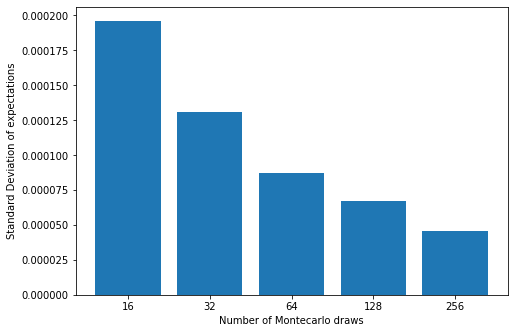

In [ ]:
# evaluate montecarlo estimation of expectation
env = Model()
rng_mc = random.PRNGKey(0)
obs_init = env.initial_obs(rng_mc)
nn_policy = MLP_softplus(config["layers"] + [env.n_actions])
nn_forward = nn_policy.apply

def get_expectation_fn(nn_forward, params, env):
  def expectation(n_draws, rng,  obs):
    policy = nn_forward(params, obs)
    mc_obs = env.mc_shocks(rng, mc_draws=n_draws)
    mc_nextobs = jax.vmap(env.step, in_axes=(None, None,0))(obs, policy, mc_obs)
    mc_nextpols = nn_forward(params,jnp.stack(mc_nextobs))
    exp = jnp.mean(jax.vmap(env.expect_realization)(mc_nextobs, mc_nextpols))
    return exp
  return expectation

rng_mc, *mc_rngs = jax.random.split(rng_mc, 100 + 1)

obs_list = [obs_init]
n_draws_list = [16, 32, 64, 128, 256]
# n_draws_list = [500, 1000]
rng_list =list(mc_rngs)

mc_explist = {n_draws_list[i]: [] for i in range(len(n_draws_list))}
mc_error = {f"error_{n_draws_list[i]}_draws": [] for i in range(len(n_draws_list))}
for i in range(len(n_draws_list)):
  for j in range(len(rng_list)):
    for k in range(len(obs_list)):
      # exp_jitted = jax.jit(get_expectation_fn(nn_forward, params, env)).lower(n_draws_list[i], rng_list[j], obs_list[k]).compile
      mc_explist[n_draws_list[i]].append(get_expectation_fn(nn_forward, params_trained, env)(n_draws_list[i], rng_list[j],  obs_list[k]))
      # mc_eval[(i,j,k)] = exp_jitted(n_draws_list[i], rng_list[j],  obs_list[k])
  mc_error[f"error_{n_draws_list[i]}_draws"] = jnp.std(jnp.array(mc_explist[n_draws_list[i]]))
print(mc_error)

error_list = [float(mc_error[f"error_{n_draws_list[i]}_draws"]) for i in range(len(n_draws_list))]
print(error_list)
n_drawsstr_list = [str(n_draws_list[i]) for i in range(len(n_draws_list))]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(n_drawsstr_list, error_list)
plt.xlabel('Number of Montecarlo draws')
plt.ylabel('Standard Deviation of expectations')
# plt.show
fig.savefig(config['working_dir']+config['run_name']+'/mc_eval.jpg', bbox_inches="tight", pad_inches=1)
  

## Analysis

We now perform three analysis. First, we analyse business cycle frequencies and amplifications.

In [ ]:
""" Calculate fourier transform """

# simulate 100000 periods
rng_test = random.PRNGKey(0)
env = Model()
n_periods = 1000000
state_init = jnp.array(jnp.log(jax.random.uniform(rng_test,(2*env.n_sectors,),minval=0.9,maxval=1.1)))
shocks = jax.random.multivariate_normal(rng_test, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(n_periods,))
_, state_policy_pairs = lax.scan(env.step,state_init,shocks)
states, _ = state_policy_pairs
print(states.shape) #check that last dimension is the time dimension
fourier = jax.scipy.fft.dct(states)
del states
del shocks


TypeError: ignored

## Analysis 2: Impulse of responses of larges sectors

In [ ]:
# Impulse responses of dynare policy vs learned policy
env = Model()
obs_ss = jnp.zeros_like(env.states_ss)

shokcs_dir = {
    f"e_ir_{i}": jnp.concatenate([jnp.array([env.states_sd[2*env.n_sectors+i]]),jnp.zeros((env.n_sectors-1,))]) 
    for i in range(env.n_sectors)}
state_init = jnp.zeros(shape = 3*env.n_sectors)

shocks = jnp.zeros((40, env.n_sectors))
state_final, train_pairs = lax.scan(env.step, state_init, shocks)
obs, policy = train_pairs
alt_policy = MLP_softplus.apply(params,obs)
plt.plot(list(range(40)) ,policy[:,0], label ="dynare policy")
plt.plot(list(range(40)) ,alt_policy[:,0], label ="neural net policy")
plt.plot(list(range(40)), [jnp.exp(env.ss_policy[0]) for i in range(config["length_IR"])])
plt.legend()
plt.savefig(config['working_dir']+config['run_name']+'/IR.jpg')
plt.close()

AttributeError: ignored

## Obsolete

In [ ]:
# def loss(self, rng, state, policy_params):
    
  #   # process state
  #   state = state*self.states_sd
  #   K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
  #   a = state[self.n_sectors:]+self.states_ss[self.n_sectors:]

  #   # calculate the policy variables
  #   policy = self.policy_fn(policy_params,state) 
  #   I = policy[:self.n_sectors]
  #   Q = policy[self.n_sectors:2*self.n_sectors]
  #   P = policy[2*self.n_sectors:3*self.n_sectors]
  #   L = policy[3*self.n_sectors:]

  #   #Rest of variables
  #   A = jnp.exp(a)
  #   Lagg = jnp.sum(L)  # Aggregate labor
  #   Pagg = jnp.dot(jnp.transpose(self.xi),P**(1-self.sigma_c))**(1/(1-self.sigma_c)) # Agg price
  #   Cagg = 1/Pagg  # Agg consumption
  #   C = self.xi * (P/Pagg)**(-self.sigma_c) * Cagg  # Sectoral Consumption
  #   Pm = (jnp.dot(jnp.transpose(self.Gamma_M),P**(1-self.sigma_m)))**(1/(1-self.sigma_m)) #  Interm. Price Index
  #   M = self.mu * (Pm/P)**(-self.sigma_q) * Q  # Sectoral Intermediates
  #   Mout = P**(-self.sigma_m) * jnp.dot(self.Gamma_M,Pm**(self.sigma_m)*M) # interm sold by sector
  #   Pk = (jnp.dot(jnp.transpose(self.Gamma_I),P**(1-self.sigma_I)))**(1/(1-self.sigma_I)) #  Capital Price Index
  #   Iout = P**(-self.sigma_I) * jnp.dot(self.Gamma_I,Pk**(self.sigma_I)*I) # New Capital sold by sector
  #   Y = (A * (
  #       self.alpha**(1/self.sigma_y)*K**((self.sigma_y-1)/self.sigma_y) + 
  #       (1-self.alpha)**(1/self.sigma_y)*L**((self.sigma_y-1)/self.sigma_y) 
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #   # Now we calculate the expectation term through montecarlo. We know K_next    
  #   K_next = (1-self.delta)*K + I  # get next K
    
  #   # First, we get what is inside expectations for the realization of one shock
  #   def exp_realization(shock):
  #     # get next state
  #     a_next = self.rho*a + shock
  #     state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss
      
  #     #calculate policies
  #     policy_next = self.policy_fn(policy_params,state_next) 
  #     I_next = policy_next[:self.n_sectors]
  #     Q_next = policy_next[self.n_sectors:2*self.n_sectors]
  #     P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
  #     L_next = policy_next[3*self.n_sectors:]

  #     # Solve for the rest of the endogenous variables
  #     A_next = jnp.exp(a_next)
  #     Lagg = jnp.sum(L)
  #     Pk_next = (jnp.dot(jnp.transpose(self.Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
  #     Y_next = (A_next * (
  #       self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) + 
  #       (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y) 
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #     # Solve for the expectation term
  #     exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
  #       ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
  #       (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
  #       (1-self.delta)*Pk_next)
  #     return exp_realization
    
  #   # Now we calculate the expectation through montecarlo 
  #   def monte_carlo_exp(rng, mc_draws):
  #     shocks = jax.random.multivariate_normal(rng, jnp.zeros((self.n_sectors,)), self.Sigma_A, shape=(mc_draws,))
  #     exp = jnp.mean(jax.vmap(exp_realization)(shocks),axis=0)
  #     return exp
  #   # exp = monte_carlo_exp(rng, self.mc_draws)
  #   # rng, *mc_rngs  = random.split(rng,self.n_mcs+1)
  #   exp = monte_carlo_exp(rng,self.mc_draws)
    
  #   # Calculate model implied Q
  #   Qmod = ((
  #       (1-self.mu)**(1/self.sigma_q)*Y**((self.sigma_q-1)/self.sigma_q) + 
  #       (self.mu)**(1/self.sigma_q)*M**((self.sigma_q-1)/self.sigma_q) 
  #       )**(self.sigma_q/(self.sigma_q-1)))
    
  #   # Calculate right hand side of error eq for L
  #   Lmod = (P*A**((self.sigma_y-1)/self.sigma_y) * 
  #     ((1-self.mu)*Q/Y)**(1/self.sigma_q) * 
  #     ((1-self.alpha)*Y/L)**(1/self.sigma_y))

  #   Q_loss = Q / Qmod - 1
  #   Pk_loss = Pk/(self.beta*exp) - 1
  #   Market_loss = Q / (C+Mout+Iout) - 1
  #   L_loss = Lagg**(1/self.eps_l)/Lmod - 1
  #   loss = (jnp.sum(jnp.array([jnp.square(Q_loss),jnp.square(Pk_loss),jnp.square(Market_loss), jnp.square(L_loss)])))/self.n_actions

  #   return lax.stop_gradient(loss)

  # def expectation(self, rng, state, K_next, policy_params):
  #   K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
  #   a = state[self.n_sectors:]

  #   def exp_realization(shock):
  #     # get next state
  #     a_next = self.rho*a + shock
  #     state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss
      
  #     #calculate policies
  #     policy_next = self.policy_fn(policy_params,state_next) 
  #     I_next = policy_next[:self.n_sectors]
  #     Q_next = policy_next[self.n_sectors:2*self.n_sectors]
  #     P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
  #     L_next = policy_next[3*self.n_sectors:]

  #     # Solve for the rest of the endogenous variables
  #     A_next = jnp.exp(a_next)
  #     Lagg = jnp.sum(L)
  #     Pk_next = (jnp.dot(jnp.transpose(self.Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
  #     Y_next = (A_next * (
  #       self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) + 
  #       (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y) 
  #       )**(self.sigma_y/(self.sigma_y-1)))

  #     # Solve for the expectation term
  #     exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
  #       ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
  #       (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
  #       (1-self.delta)*Pk_next)
  #     return exp_realization

  #   shocks = jax.random.multivariate_normal(rng, jnp.zeros((self.n_sectors,)), self.Sigma_A, shape=(self.mc_draws,))
  #   exp = jnp.mean(jax.vmap(exp_realization)(shocks), axis=0)
  #   return exp

In [ ]:
# Environment
# class ProdNetRbc_SS():
#   """A JAX implementation of an RBC model with Production Networks."""

#   def __init__(self, params = params, states_ss=states_ss, policies_ss=policies_ss, states_sd = states_sd, policy_layers=[1024,1024]):

#     self.alpha = params["alpha"]
#     self.beta = params["beta"]
#     self.delta = params["delta"]
#     self.rho = params["rho"]
#     self.eps_l = params["eps_l"]
#     self.sigma_c = params["sigma_c"]
#     self.sigma_m = params["sigma_m"]
#     self.sigma_q = params["sigma_q"]
#     self.sigma_y = params["sigma_y"]
#     self.sigma_I = params["sigma_I"]
#     self.xi = jnp.array(params["xi"])
#     self.mu = jnp.array(params["mu"])
#     self.Gamma_M = jnp.array(params["Gamma_M"])
#     self.Gamma_I = jnp.array(params["Gamma_I"])
#     self.n_sectors = params["n_sectors"]
#     self.states_ss = jnp.concatenate([states_ss,jnp.zeros(shape=(self.n_sectors,))])
#     self.policies_ss = jnp.array(policies_ss)
#     self.n_actions = 4*self.n_sectors
#     self.states_sd = states_sd
#   def initial_state(self):
#     state_init = jnp.zeros(shape=(2*self.n_sectors,))
#     return lax.stop_gradient(state_init)

#   def step(self, state): 
#     state = state*self.states_sd
#     K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])
#     a = state[self.n_sectors:]
#     policy = jnp.exp(self.policies_ss)
#     K_next = (1-self.delta)*K + policy[:self.n_sectors]
#     a_next = self.rho*a
#     state_next = (jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss)/self.states_sd
#     # return lax.stop_gradient(state_next), lax.stop_gradient(state_next)
#     return lax.stop_gradient(state_next)


#   def loss(self, state):
#     state = state*self.states_sd
#     # process state
#     K = jnp.exp(state[:self.n_sectors]+self.states_ss[:self.n_sectors])

#     # calculate the policy variables
#     policy = jnp.exp(self.policies_ss)
#     I = policy[:self.n_sectors]
#     Q = policy[self.n_sectors:2*self.n_sectors]
#     P = policy[2*self.n_sectors:3*self.n_sectors]
#     L = policy[3*self.n_sectors:]
  
#     #Rest of variables
#     Lagg = jnp.sum(L)  # Aggregate labor
#     Pagg = jnp.dot(jnp.transpose(self.xi),P**(1-self.sigma_c))**(1/(1-self.sigma_c)) # Agg price
#     Cagg = 1/Pagg  # Agg consumption
#     C = self.xi * (P/Pagg)**(-self.sigma_c) * Cagg  # Sectoral Consumption
#     Pm = (jnp.dot(jnp.transpose(self.Gamma_M),P**(1-self.sigma_m)))**(1/(1-self.sigma_m)) #  Interm. Price Index
#     M = self.mu * (Pm/P)**(-self.sigma_q) * Q  # Sectoral Intermediates
#     Mout = P**(-self.sigma_m) * jnp.dot(self.Gamma_M,Pm**(self.sigma_m)*M) # interm sold by sector
#     Pk = (jnp.dot(jnp.transpose(self.Gamma_I),P**(1-self.sigma_I)))**(1/(1-self.sigma_I)) #  Capital Price Index
#     Iout = P**(-self.sigma_I) * jnp.dot(self.Gamma_I,Pk**(self.sigma_I)*I) # New Capital sold by sector
#     Y = (
#         (
#         self.alpha**(1/self.sigma_y)*K**((self.sigma_y-1)/self.sigma_y) + 
#         (1-self.alpha)**(1/self.sigma_y)*L**((self.sigma_y-1)/self.sigma_y) 
#         )**(self.sigma_y/(self.sigma_y-1)))
    
#     print(Y)
#     # Now we calculate the expectation term through montecarlo. We know K_next
#     K_next = (1-self.delta)*K + I  # get next K
#     exp = (
#         P *
#         ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
#         (self.alpha*Y/K_next)**(1/self.sigma_y) +
#         (1-self.delta)*Pk
#         )
#     # Now we get what is inside expectations for each realization of the shock
#     # def exp_realization():
#     #   # a_next = self.rho*a       
#     #   # state_next = jnp.concatenate([jnp.log(K_next),a_next])-self.states_ss
      
#     #   #calculate policies
#     #   # policy_next = policy
#     #   # I_next = policy_next[:self.n_sectors]
#     #   # Q_next = policy_next[self.n_sectors:2*self.n_sectors]
#     #   # P_next = policy_next[2*self.n_sectors:3*self.n_sectors]
#     #   # L_next = policy_next[3*self.n_sectors:]

#     #   # Solve for the rest of the endogenous variables
#     #   # A_next = jnp.exp(a_next)
#     #   # Lagg = jnp.sum(L)
#     #   # Pk_next = (jnp.dot(jnp.transpose(Gamma_I),P_next**(1-self.sigma_I)))**(1/(1-self.sigma_I))
#     #   # Y_next = (A_next * (
#     #   #   self.alpha**(1/self.sigma_y)*K_next**((self.sigma_y-1)/self.sigma_y) + 
#     #   #   (1-self.alpha)**(1/self.sigma_y)*L_next**((self.sigma_y-1)/self.sigma_y) 
#     #   #   )**(self.sigma_y/(self.sigma_y-1)))

#     #   # Solve for the expectation term
#     #   # exp_realization = (P_next*A_next**((self.sigma_y-1)/self.sigma_y) *
#     #   #   ((1-self.mu)*Q_next/Y_next)**(1/self.sigma_q) *
#     #   #   (self.alpha*Y_next/K_next)**(1/self.sigma_y) +
#     #   #   (1-self.delta)*Pk_next)
#     #   exp_realization = (P*A**((self.sigma_y-1)/self.sigma_y) *
#     #     ((1-self.mu)*Q/Y)**(1/self.sigma_q) *
#     #     (self.alpha*Y/K_next)**(1/self.sigma_y) +
#     #     (1-self.delta)*Pk)
#     #   return exp_realization

#     # Now we calculate the expectation

#     # Calculate model implied Q
#     Qmod = ((
#         (1-self.mu)**(1/self.sigma_q)*Y**((self.sigma_q-1)/self.sigma_q) + 
#         (self.mu)**(1/self.sigma_q)*M**((self.sigma_q-1)/self.sigma_q) 
#         )**(self.sigma_q/(self.sigma_q-1)))

#     # Calculate right hand side of error eq for L
#     Lmod = (P * 
#       ((1-self.mu)*Q/Y)**(1/self.sigma_q) * 
#       ((1-self.alpha)*Y/L)**(1/self.sigma_y))

#     Q_loss = Q / Qmod - 1
#     Pk_loss = Pk/(self.beta*exp) - 1
#     Market_loss = Q / (C+Mout+Iout) - 1
#     L_loss = Lagg**(1/self.eps_l)/Lmod - 1
#     loss = (jnp.sum(jnp.array([jnp.square(Q_loss),jnp.square(Pk_loss),jnp.square(Market_loss), jnp.square(L_loss)])))/self.n_actions

#     return lax.stop_gradient(loss)

In [ ]:
def run_experiment(env, config):
  """Runs experiment."""
  cores_count = len(jax.devices())  # get available TPU cores.
  nn_policy = MLP_softplus(config["layers"] + [env.n_actions])
  optim = optax.adam(config["learning_rate"])  # define optimiser.

  rng, rng_e = random.split(random.PRNGKey(config["seed"]), 2)  # prng keys.
  dummy_obs = env.initial_obs(rng_e)  # dummy for net init.
  params = params # initialise params.
  nn_forward = nn_policy.apply
  mean_loss = jnp.array([0.0]) # initialize loss
  # mean_abs_loss = jnp.array([0.0]) # initialize loss
  opt_state = optim.init(params)  # initialise optimiser stats.
  learn = jax.jit(get_epoque_learner_fn(env, nn_forward, optim.update, config["batch_size"], config["epoque_iters"]))
  # learn = jax.pmap(learn, axis_name='i')  # replicate over multiple cores.

  #  broadcast = lambda x: jnp.broadcast_to(x, (cores_count, config["n_batches"]) + x.shape)
  # params = jax.tree_map(broadcast, params)  # broadcast to cores and batch.
  # opt_state = jax.tree_map(broadcast, opt_state)  # broadcast to cores and batch
  # mean_loss = jax.tree_map(broadcast, mean_loss)
  # mean_abs_loss = jax.tree_map(broadcast, mean_abs_loss)

  # rng, *env_rngs = jax.random.split(rng, cores_count * config["n_batches"]+ 1)
  # env_obs = jax.vmap(env.initial_obs)(jnp.stack(env_rngs))  # init envs.
  # rng, *step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  # rng, *eval_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  rng, env_rngs = jax.random.split(rng, cores_count * config["n_batches"]+ 1)
  env_obs = env.initial_obs(env_rngs)  # init envs.
  rng, step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
  rng, eval_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)

  # reshape = lambda x: x.reshape((cores_count, config["n_batches"]) + x.shape[1:])
  # step_rngs = reshape(jnp.stack(step_rngs))  # add dimension to pmap over.
  # eval_rngs = reshape(jnp.stack(eval_rngs))  # add dimension to pmap over.
  # env_obs = reshape(env_obs)  # add dimension to pmap over.

  mean_losses = []
  mean_accuracy = []
  num_steps = cores_count * config["epoque_iters"] * config["batch_size"] * config["n_batches"]

  with TimeIt(tag='COMPILATION'):
    learn(params, opt_state, step_rngs, env_obs, mean_loss)  # compiles

  #First run, we calculate periods per second
  with TimeIt(tag='EXECUTION', steps=num_steps):
    params, opt_state, step_rngs, env_obs, mean_loss = learn(
        params, opt_state, step_rngs, env_obs, mean_loss)
  
  #Rest of the runs
  for i in range(2,config["n_epoques"]+1):
    rng, step_rngs = jax.random.split(rng, cores_count * config["n_batches"] + 1)
    # step_rngs = reshape(jnp.stack(step_rngs))
    params, opt_state, step_rngs, env_obs, mean_loss = learn( 
        params, opt_state, step_rngs, env_obs, mean_loss) 
    
    mean_losses.append(jnp.mean(mean_loss)) 
    # mean_accuracy.append((1- jnp.mean(mean_abs_loss))*100)
      
    print('Iteration:', i*config["epoque_iters"], 
          ", Mean_loss:", jnp.mean(mean_loss),
          ", Learning rate:", config["learning_rate"](i*config["epoque_iters"]), 
          # ", Mean accuracy (%):", (1- jnp.mean(mean_abs_loss))*100
          )
    
    if i%config["reset_env_nepoques"]==0:
      env_obs = jnp.zeros_like(env_obs)
      print("ENV RESET")

  # Print best result
  # print("Maximum accuracy attained in training:", max(mean_accuracy))
  
  #Checkpoint
  checkpoints.save_checkpoint(ckpt_dir=config['working_dir']+config['run_name'], target=params, step=config["n_epoques"]*config["epoque_iters"])

  # Plots
  plt.plot([i for i in range(len(mean_losses[100:]))], mean_losses[100:])
  plt.xlabel('Steps')
  plt.ylabel('Mean Losses')
  plt.savefig(config['working_dir']+config['run_name']+'/mean_losses.jpg')
  plt.close()

 
  return params, optim, nn_policy, mean_losses, mean_accuracy

In [ ]:
def get_epoque_learner_fn(
    env, nn_forward, opt_update, batch_size, epoque_iters):
  """It runs and epoque with learing. This is what the compiler reads and parallelize (the minimal unit of computation)."""

  def period_loss_fn(nn_params, loss_rng, env_obs):
    
    # get rngs
    loss_rng, mc_rng = random.split(loss_rng,2)

    # Step the environemnt
    period_shock = jax.random.multivariate_normal(loss_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A/100)
    policy = nn_forward(nn_params, env_obs)
    obs_final = env.step(env_obs, policy, period_shock)  # apply period steps for each row shock in shocks.
    
    # calculate exp
    mc_shocks = jax.random.multivariate_normal(mc_rng, jnp.zeros((env.n_sectors,)), env.Sigma_A, shape=(200000,))
    mc_nextobs = jax.vmap(env.step, in_axes=(None, None, 0))(env_obs, policy, mc_shocks)
    del mc_shocks
    mc_nextpols = nn_forward(nn_params,jnp.stack(mc_nextobs))
    exp = jnp.mean(jax.vmap(env.exp_realization)(mc_nextobs, mc_nextpols))

    loss = env.loss(env_obs, exp, policy)
    
    return loss, (obs_final, jnp.array([loss]))

  def update_fn(nn_params, opt_state, rng, env_obs, mean_loss):
    """Compute a gradient update from a single trajectory."""
    rng, loss_rng = random.split(rng,2)
    grads, aux_info  = jax.grad(  # compute gradient on a single trajectory.
        period_loss_fn, has_aux=True)(nn_params, loss_rng, env_obs)
    new_env_obs, mean_loss = aux_info
    # grads = lax.pmean(grads, axis_name='j')  # reduce mean (average grads) across cores.
    # grads = lax.pmean(grads, axis_name='i')  # reduce mean (average grads) across batch.
    updates, new_opt_state = opt_update(grads, opt_state)  # transform grads.
    new_params = optax.apply_updates(nn_params, updates)  # update parameters.
    return new_params, new_opt_state, rng, new_env_obs, mean_loss

  # def learner_fn(params, opt_state, rngs, env_obs, mean_loss):
  #   """Vectorise and repeat the update."""
  #   batched_update_fn = jax.vmap(update_fn, axis_name='j')  # vectorize across batch.
  #   def iterate_fn(_, val):  # repeat many times to avoid going back to Python.
  #     params, opt_state, rngs, env_obs, mean_loss = val
  #     return batched_update_fn(params, opt_state, rngs, env_obs, mean_loss)
  #   return lax.fori_loop(0, epoque_iters, iterate_fn, (
  #       params, opt_state, rngs, env_obs, mean_loss))

  return update_fn